In [76]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, Add, Dropout
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [77]:
import tensorflow.keras.backend as K
import gc
from keras import optimizers
from tqdm.notebook import tqdm_notebook

In [96]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.4.0


In [147]:
'''----------LOAD DATA----------------'''

data_dir = "./competition_data"

nrows = 1000
if isinstance(nrows, int) and nrows>0:
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0], nrows=nrows)
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
elif isinstance(nrows, str) and nrows.upper() == "ALL":
    train_df = pd.read_csv(data_dir+"/train.csv", index_col="id", usecols=[0])
    depths_df = pd.read_csv(data_dir+"/depths.csv", index_col="id")
    train_df = train_df.join(depths_df)
    test_df = depths_df[~depths_df.index.isin(train_df.index)]
else:
    raise ValueError("Invalid nrows value")

#train_df["images"] = [img_to_array(load_img(data_dir+"/train/images/{}.png".format(idx),
#                                        color_mode = "grayscale"), dtype="float32")/255 for idx in (train_df.index)]

#train_df["masks"] = [img_to_array(load_img(data_dir+"/train/masks/{}.png".format(idx),
#                                       color_mode = "grayscale"), dtype="float32")/65535 for idx in (train_df.index)]

print("Loading images...")
train_df["images"] = [np.array(load_img(data_dir+"/train/images/{}.png".format(idx),
                                        color_mode = "grayscale"))/255 for idx in tqdm_notebook(train_df.index)]
print("Loading masks...")
train_df["masks"] = [np.array(load_img(data_dir+"/train/masks/{}.png".format(idx),
                                       color_mode = "grayscale"))/65535 for idx in tqdm_notebook(train_df.index)]

print("done loading images")

Loading images...


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading masks...


  0%|          | 0/1000 [00:00<?, ?it/s]

done loading images


In [148]:
# -------------> data example
# printing
print("-------------------------------------------------------------")
id = '2c45b152f1'
id_index = np.where(train_df.index == id)
id_index = id_index[0][0]
print("id_index = ", id_index)
image = train_df["images"][id]
print(image)
print(image.shape)
print("-------------------------------------------------------------")
mask = train_df["masks"][id]
print(mask)
print(mask.shape)

-------------------------------------------------------------
id_index =  0
[[0.34117647 0.35686275 0.37254902 ... 0.34901961 0.34117647 0.3372549 ]
 [0.34901961 0.37254902 0.39607843 ... 0.34901961 0.34901961 0.34509804]
 [0.37647059 0.39607843 0.41176471 ... 0.34901961 0.35686275 0.34901961]
 ...
 [0.16470588 0.14117647 0.14117647 ... 0.4        0.40784314 0.41176471]
 [0.18823529 0.17254902 0.18431373 ... 0.40392157 0.41176471 0.42352941]
 [0.20392157 0.19607843 0.20392157 ... 0.40784314 0.41176471 0.42745098]]
(101, 101)
-------------------------------------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(101, 101)


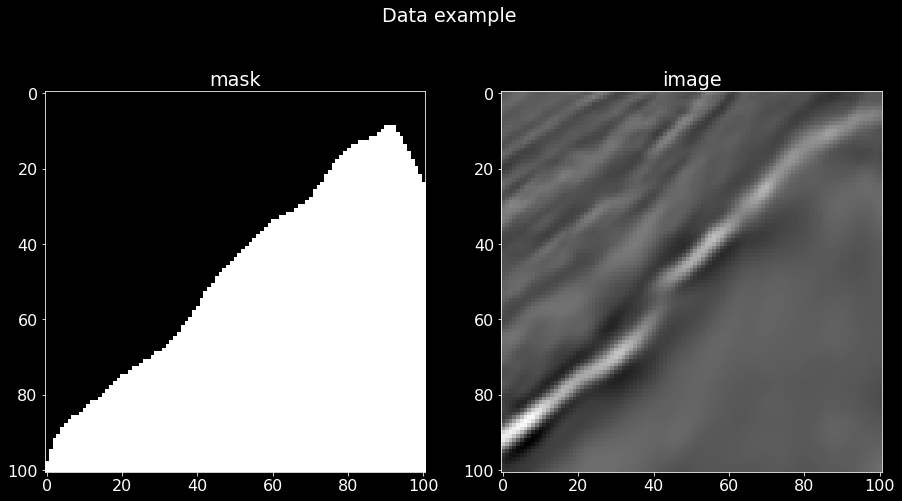

In [149]:
def plot_image_example():
    fig_imgshow, (axs_mask, axs_img) = plt.subplots(1, 2)
    fig_imgshow.suptitle("Data example")
    axs_img.imshow(np.dstack((image, image, image)))  # interpolation='nearest'
    axs_img.set(title="image")
    tmp = np.squeeze(mask).astype(np.float32)
    axs_mask.imshow(np.dstack((tmp, tmp, tmp)))
    axs_mask.set(title="mask")


plot_image_example()

# **Prepossessing Data**

#### ------> Resize to a pow of 2

In [150]:
# either pad with zeros or resize with interpolation
resize_to = 101
original_size = 101


def upsample(original_img):
    if resize_to == original_size:
        return original_img
    return resize(original_img, (resize_to, resize_to), mode='constant', preserve_range=True)


def pad_zeros(array):
    padded_image = np.zeros(shape=(resize_to, resize_to))
    padded_image[13:114, 13:114] = array
    return padded_image

In [151]:
resizing_function_to_use = upsample

images_resized = np.array(train_df.images.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))
masks_resized = np.array(train_df.masks.map(resizing_function_to_use).tolist()).reshape((-1, resize_to, resize_to, 1))

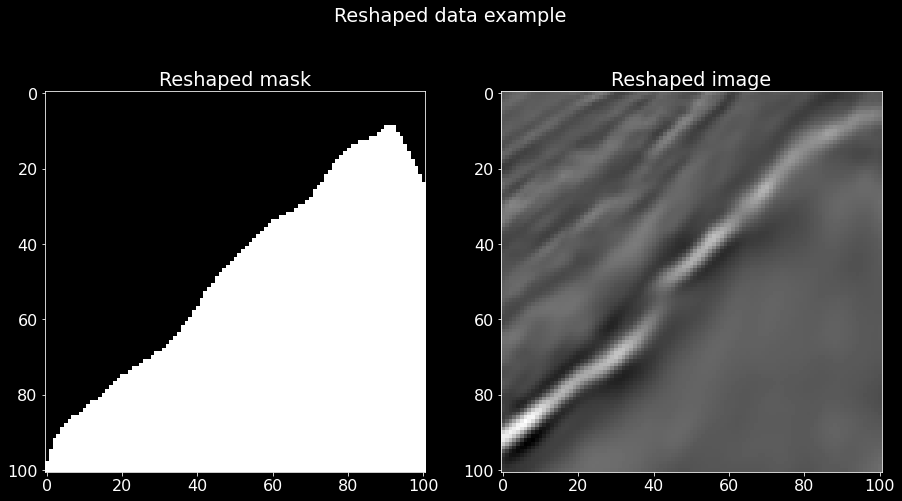

In [152]:
# Plotting
def plot_reshape_example():
    fig_reshape, (axs_reshape_mask, axs_reshape_img) = plt.subplots(1, 2)
    fig_reshape.suptitle("Reshaped data example")
    axs_reshape_img.set(title="Reshaped image")
    axs_reshape_mask.set(title="Reshaped mask")
    axs_reshape_img.imshow(images_resized[id_index], cmap='gray')
    axs_reshape_mask.imshow(masks_resized[id_index], cmap='gray')


plot_reshape_example()

#### ------> Split train/dev

In [154]:
(ids_train, ids_valid,
x_train, x_valid,
y_train, y_valid
# cov_train, cov_test,
#depth_train, depth_test
 ) = train_test_split(
    train_df.index.values,
    images_resized,
    masks_resized,
    # train_df.coverage.values,
    # train_df.z.values,
    test_size=0.001,
    # stratify=train_df.coverage_class,
    random_state=1337)

print("Train/ Valid shape = %d/ %d"%(x_train.shape[0], x_valid.shape[0]))

Train/ Valid shape = 999/ 1


#### ------> Data augmentation

In [87]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [155]:
print("x_rain shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_rain shape:  (999, 101, 101, 1)
y_train shape:  (999, 101, 101, 1)


# U-Net

#### ------> Model

In [156]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [157]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    #print("A shape: ", A.shape)
    #print("B shape: ", B.shape)
    metric = 0.0
    for batch in range(batch_size):
        
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        #print("True: ", t)
        #print("Predicted: ", p)
        #print("----------------------")
        #print("True sum: ", true)
        #print("Predicted sum: ", pred)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # Scale the iou function: iou -> 2*iou - 0.9
        # This will map the threshold values [0.5, 0.55, 0.6, ...., 0.9] to the
        # values [0.1, 0.2, 0.3, ....., 0.9]. Then multiply 2*iou - 0.9 by 10 and floor.
        # This will map the iou values to the number of thresholds that the iou sutisfies
        # witch is what we are intreasted in in the first playse.
        # For example if iou=0.552 then floor(2*iou - 0.9)*10 = 2. Since
        # eveery value <0 means an original value<0.5 we take the max with 0. Finaly we 
        # devide by 10 = |threshods|.
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [163]:
start_neurons = 16
DropoutRatio = 0.5
print("START BUILDING MODEL")
input_layer = Input((101, 101, 1))
print("BUILD INPUT")

# 101 -> 50
conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
conv1 = residual_block(conv1,start_neurons * 1)
conv1 = residual_block(conv1,start_neurons * 1, True)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(DropoutRatio/2)(pool1)

# 50 -> 25
conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
conv2 = residual_block(conv2,start_neurons * 2)
conv2 = residual_block(conv2,start_neurons * 2, True)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(DropoutRatio)(pool2)

# 25 -> 12
conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
conv3 = residual_block(conv3,start_neurons * 4)
conv3 = residual_block(conv3,start_neurons * 4, True)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(DropoutRatio)(pool3)

# 12 -> 6
conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
conv4 = residual_block(conv4,start_neurons * 8)
conv4 = residual_block(conv4,start_neurons * 8, True)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(DropoutRatio)(pool4)

# Middle
convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
convm = residual_block(convm,start_neurons * 16)
convm = residual_block(convm,start_neurons * 16, True)
    
# 6 -> 12
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(DropoutRatio)(uconv4)
    
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 8)
uconv4 = residual_block(uconv4,start_neurons * 8, True)

# 12 -> 25
#deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
uconv3 = concatenate([deconv3, conv3])    
uconv3 = Dropout(DropoutRatio)(uconv3)
    
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 4)
uconv3 = residual_block(uconv3,start_neurons * 4, True)

# 25 -> 50
deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
        
uconv2 = Dropout(DropoutRatio)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 2)
uconv2 = residual_block(uconv2,start_neurons * 2, True)

# 50 -> 101
#deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
uconv1 = concatenate([deconv1, conv1])
    
uconv1 = Dropout(DropoutRatio)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 1)
uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
#uconv1 = Dropout(DropoutRatio/2)(uconv1)
#output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
output_layer =  Activation('sigmoid')(output_layer_noActi)

START BUILDING MODEL
BUILD INPUT


In [164]:
model = Model(inputs=[input_layer], outputs=[output_layer])
print("BUILD MODEL")
adam_optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[my_iou_metric])
print("COMPILE")
model.summary()

BUILD MODEL
COMPILE
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 101, 101, 1) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 101, 101, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 101, 101, 16) 64          conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 101, 101, 16) 0           batch_normalization_117[0][0]    
________________________________________________________________________

In [161]:
epochs = 20
batch_len = 32
history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_len)

Epoch 1/20
32/32 [==============================] - 78s 2s/step - loss: 0.6468 - my_iou_metric: 0.0882
Epoch 2/20
32/32 [==============================] - 31s 973ms/step - loss: 0.4373 - my_iou_metric: 0.2330
Epoch 3/20
32/32 [==============================] - 31s 983ms/step - loss: 0.4367 - my_iou_metric: 0.2610
Epoch 4/20
32/32 [==============================] - 31s 965ms/step - loss: 0.3953 - my_iou_metric: 0.3828
Epoch 5/20
32/32 [==============================] - 31s 976ms/step - loss: 0.3842 - my_iou_metric: 0.3959
Epoch 6/20
32/32 [==============================] - 31s 982ms/step - loss: 0.4107 - my_iou_metric: 0.3947
Epoch 7/20
32/32 [==============================] - 31s 982ms/step - loss: 0.3835 - my_iou_metric: 0.4344
Epoch 8/20
32/32 [==============================] - 31s 954ms/step - loss: 0.3309 - my_iou_metric: 0.5130
Epoch 9/20
32/32 [==============================] - 31s 956ms/step - loss: 0.3490 - my_iou_metric: 0.4861
Epoch 10/20
32/32 [==============================

#### Plotting model results and cleaning up

In [66]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        print(len(hs[label].history['loss']))
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        # plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()
    
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


20


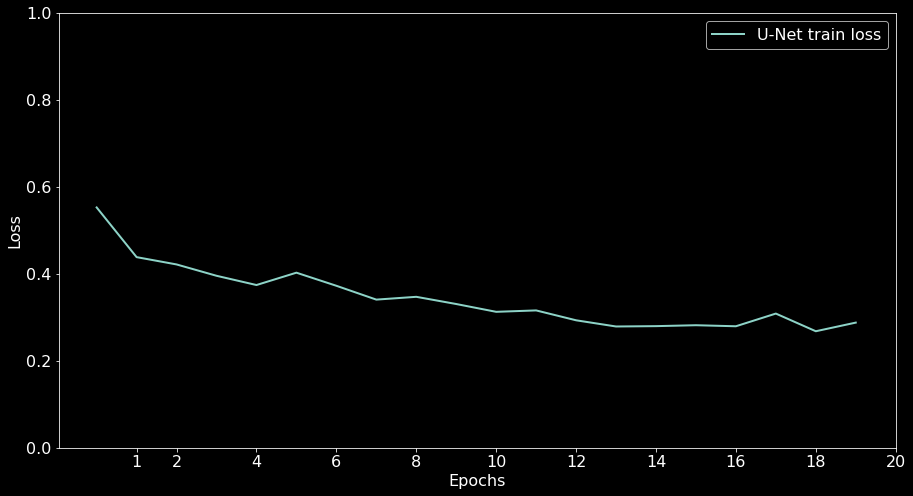


20


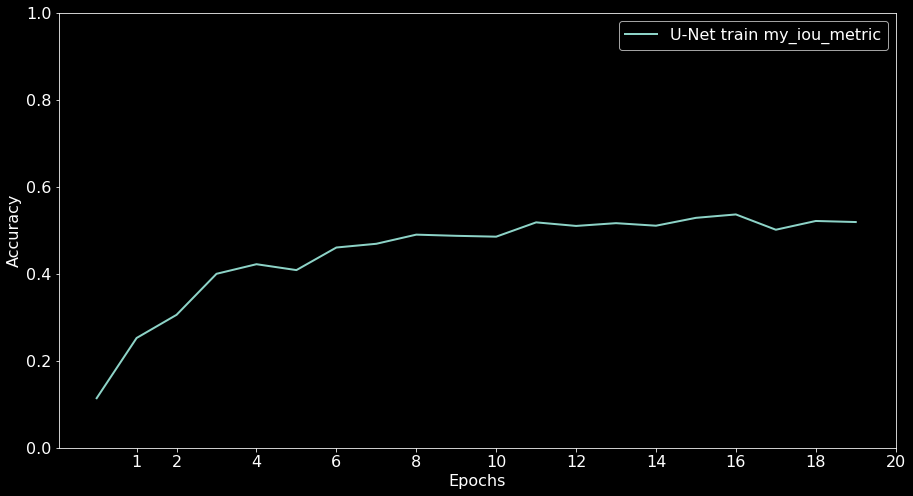

In [162]:
plot_history(hs={'U-Net': history}, epochs=epochs, metric='loss')
plot_history(hs={'U-Net': history}, epochs=epochs, metric='my_iou_metric')

In [117]:
clean_up(model)